# Descartes Underwriting - OULID AZOUZ

In [295]:
import pandas as pd
from pandas.plotting import scatter_matrix

import seaborn as sns
import numpy as np
import sklearn_pandas
import sklearn
import scipy.stats
import missingno as msno

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('fivethirtyeight')

# Get and explore data

In [4]:
data = pd.read_csv("train_auto.csv")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   INDEX        8161 non-null   int64  
 1   TARGET_FLAG  8161 non-null   int64  
 2   TARGET_AMT   8161 non-null   float64
 3   KIDSDRIV     8161 non-null   int64  
 4   AGE          8155 non-null   float64
 5   HOMEKIDS     8161 non-null   int64  
 6   YOJ          7707 non-null   float64
 7   INCOME       7716 non-null   object 
 8   PARENT1      8161 non-null   object 
 9   HOME_VAL     7697 non-null   object 
 10  MSTATUS      8161 non-null   object 
 11  SEX          8161 non-null   object 
 12  EDUCATION    8161 non-null   object 
 13  JOB          7635 non-null   object 
 14  TRAVTIME     8161 non-null   int64  
 15  CAR_USE      8161 non-null   object 
 16  BLUEBOOK     8161 non-null   object 
 17  TIF          8161 non-null   int64  
 18  CAR_TYPE     8161 non-null   object 
 19  RED_CA

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


The database is made of 8161 entries and 26 columns (the Index, 2 targets, and 23 features to use). 


First, let's check about any double ID we could have.

In [5]:
data['INDEX'].value_counts()

1        1
6874     1
6890     1
6889     1
6888     1
        ..
3444     1
3441     1
3440     1
3439     1
10302    1
Name: INDEX, Length: 8161, dtype: int64

Seems like we are good and have no double ID's : the maximum is number of line for one ID is 1. Regarding the index columns, it looks the data were already processed before (jumps from an ID to another). Let's use INDEX as the df index.

In [119]:
df = data.set_index('INDEX')

## Framing the problem and looking at the big picture

Let's try to understand the problem that this dataset confronts us with. Let's first look at what the features and the target in order to understand the context. The target for this project is TARGET_FLAG.

In [120]:
#to have an idea of our target: 
df['TARGET_FLAG'].value_counts()

0    6008
1    2153
Name: TARGET_FLAG, dtype: int64

 Considering the variables and the values taken by the target, it seems that the problem consists in training a model to determine if the individual presents a risk accident (and so using its insurance policy) taking into account all the other parameters. 

The variable  two values (0 and 1), so we are facing a supervised problem of binary classification.

Regarding TARGET_AMT, it looks like the data is non 0 only when TARGET_FLAG is 1. This target might correspond to a claim amount and it makes us understand that TARGET_FLAG=1 means there was a claim from the policyholder (so the car was involved in a crash/accident).


Regarding the distribution, one must see we have a lot more of 0 than 1. The dataset is imbalanced and we keep this in mind for later. 

As we are not interested in predicting the amount for this problem, we just drop the column : 



In [121]:
df=df.drop(['TARGET_AMT'], axis=1)

## Understanding the features :

Here we are going to assume the potential meaning of our features. 

In [76]:
df.columns

Index(['TARGET_FLAG', 'KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'SEX', 'EDUCATION', 'JOB', 'TRAVTIME',
       'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

- 'KIDSDRIV' => For how many kids did the policyholder insured its car 
- 'AGE' => Age of the policyholder
- 'HOMEKIDS'=> How many kids at home
- 'YOJ' => Not sure, might be something like year on J.. ? 
- 'INCOME' => Income per year 
- PARENT1' => If the policyholder is the only parent in charge of its kids (divorced or single parent)
- HOME_VAL => Value of their home
- MSTATUS => if married
- SEX' => sex (not usable in France for insurance pricing !)
- EDUCATION => Education level 
- 'JOB' => The category of job involved in
- TRAVTIME => travel time (not sure about the metric it is expressed in) but linked to the time spent in the car
- 'CAR_USE' => For what kind of activity is used the car
- BLUEBOOK' => the bluebook value is the value of the car in case of selling
- 'TIF' => idk
- 'CAR_TYPE' => 
- 'RED_CAR' => If the car color is RED (found it a little bit strange but why not, might found a surprising effect !)
- 'OLDCLAIM => amount of older claims 
- 'CLM_FREQ' => represents a kind of risk exposure for the insurer
- 'REVOKED' => might refers to potential driving license revocation 
- 'MVR_PTS' => idk (its distribution suggests its related to driving points as it goes from 0 to 12)
- 'CAR_AGE' => age of the car 
- 'URBANICITY' => refers to the environment of use of the car

### Data Types

We now explore the structure of our features before trying to interpret their effect on the target. 


We use the info() method to get a quick description of the data: the total number of rows, the type of each feature and the number of non-zero values. 

In [19]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   object 
 6   PARENT1      8161 non-null   object 
 7   HOME_VAL     7697 non-null   object 
 8   MSTATUS      8161 non-null   object 
 9   SEX          8161 non-null   object 
 10  EDUCATION    8161 non-null   object 
 11  JOB          7635 non-null   object 
 12  TRAVTIME     8161 non-null   int64  
 13  CAR_USE      8161 non-null   object 
 14  BLUEBOOK     8161 non-null   object 
 15  TIF          8161 non-null   int64  
 16  CAR_TYPE     8161 non-null   object 
 17  RED_CAR      8161 non-null   object 
 18  OLDCLAIM     8161 non-null   object 
 19  CLM_F

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


There is a lot of numerical features (float or int) and some numerical features have their type classified as objects (HOME_VAL, OLD_CLAIM ...) : we'll need to take care of it. Some other features are clearly categorical and we will decide later how to transform them and make them usable for our algorithm (RED CAR, JOB...)

In [123]:
convert_to_float=['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
for col in convert_to_float:
    df[col]= df[col].str.replace(',','.').str.replace('$','').astype('float64')
    #replace , by . and $ by empty string so the conversion work
    

/tmp/ipykernel_6821/2456317383.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]= df[col].str.replace(',','.').str.replace('$','').astype('float64')


In [124]:
df[convert_to_float].dtypes #check the conversion 

INCOME      float64
HOME_VAL    float64
BLUEBOOK    float64
OLDCLAIM    float64
dtype: object

We converted clearly numerical features (detected as objects) to float. We now dive in the missing values.

### Missing values

In [125]:
#inspect missing values
missing=pd.Series(df.isnull().sum()/len(df)*100, name='Missing Values %')
print(missing)

TARGET_FLAG    0.000000
KIDSDRIV       0.000000
AGE            0.073520
HOMEKIDS       0.000000
YOJ            5.563044
INCOME         5.452763
PARENT1        0.000000
HOME_VAL       5.685578
MSTATUS        0.000000
SEX            0.000000
EDUCATION      0.000000
JOB            6.445289
TRAVTIME       0.000000
CAR_USE        0.000000
BLUEBOOK       0.000000
TIF            0.000000
CAR_TYPE       0.000000
RED_CAR        0.000000
OLDCLAIM       0.000000
CLM_FREQ       0.000000
REVOKED        0.000000
MVR_PTS        0.000000
CAR_AGE        6.249234
URBANICITY     0.000000
Name: Missing Values %, dtype: float64


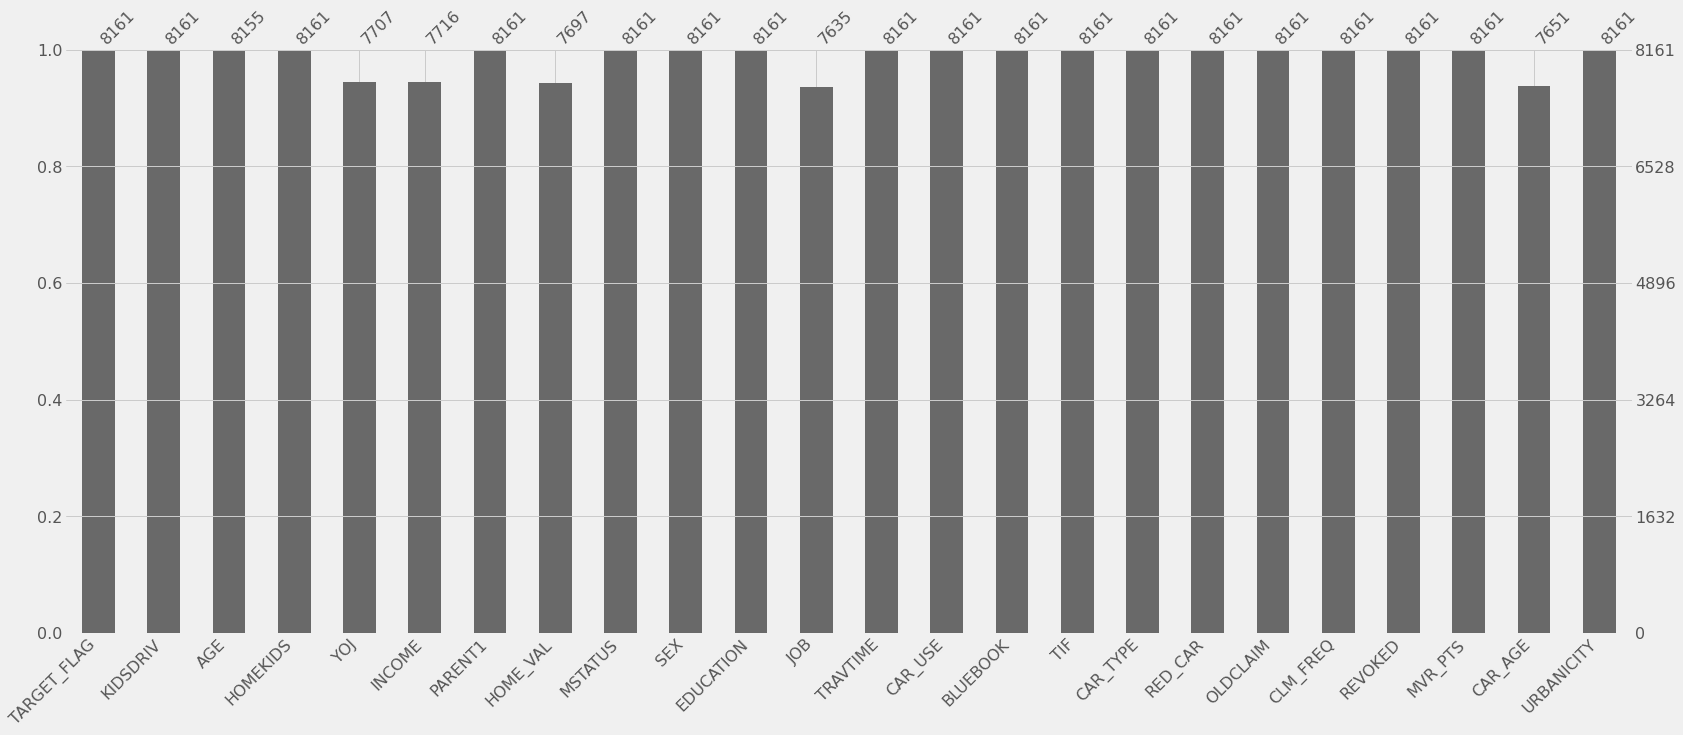

In [53]:
msno.bar(df)
plt.show()

This gives us the percentage of missing values for each features, as we can see there is at most 6.5% of the data missing for a feature, we'll need to fill them with appropriate method for each columns. Here we will try not to drop data as our database is made of only 8000 entries, which is not really large for ML algorithm. 

### Descriptive statistics

In [47]:
# summary of numerical features
df.describe()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,0.171057,44.790313,0.721235,10.499286,64.757855,154.867290,33.485725,15.709900,5.351305,13.313173,0.798554,1.695503,8.328323
std,0.440728,0.511534,8.627589,1.116323,4.092474,60.768449,129.123775,15.908333,8.419734,4.146635,85.538813,1.158453,2.147112,5.700742
min,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.500000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,39.000000,0.000000,9.000000,28.696250,0.000000,22.000000,9.280000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,45.000000,0.000000,11.000000,54.799500,161.160000,33.000000,14.440000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,0.000000,51.000000,1.000000,13.000000,87.259000,238.724000,44.000000,20.850000,7.000000,4.906000,2.000000,3.000000,12.000000
max,1.000000,4.000000,81.000000,5.000000,23.000000,997.000000,885.282000,142.000000,69.740000,25.000000,999.000000,5.000000,13.000000,28.000000


The average driver in the insurer portfolio is 44y old and drive the same car for about 8.3y in average. We can also plot the distributions : 

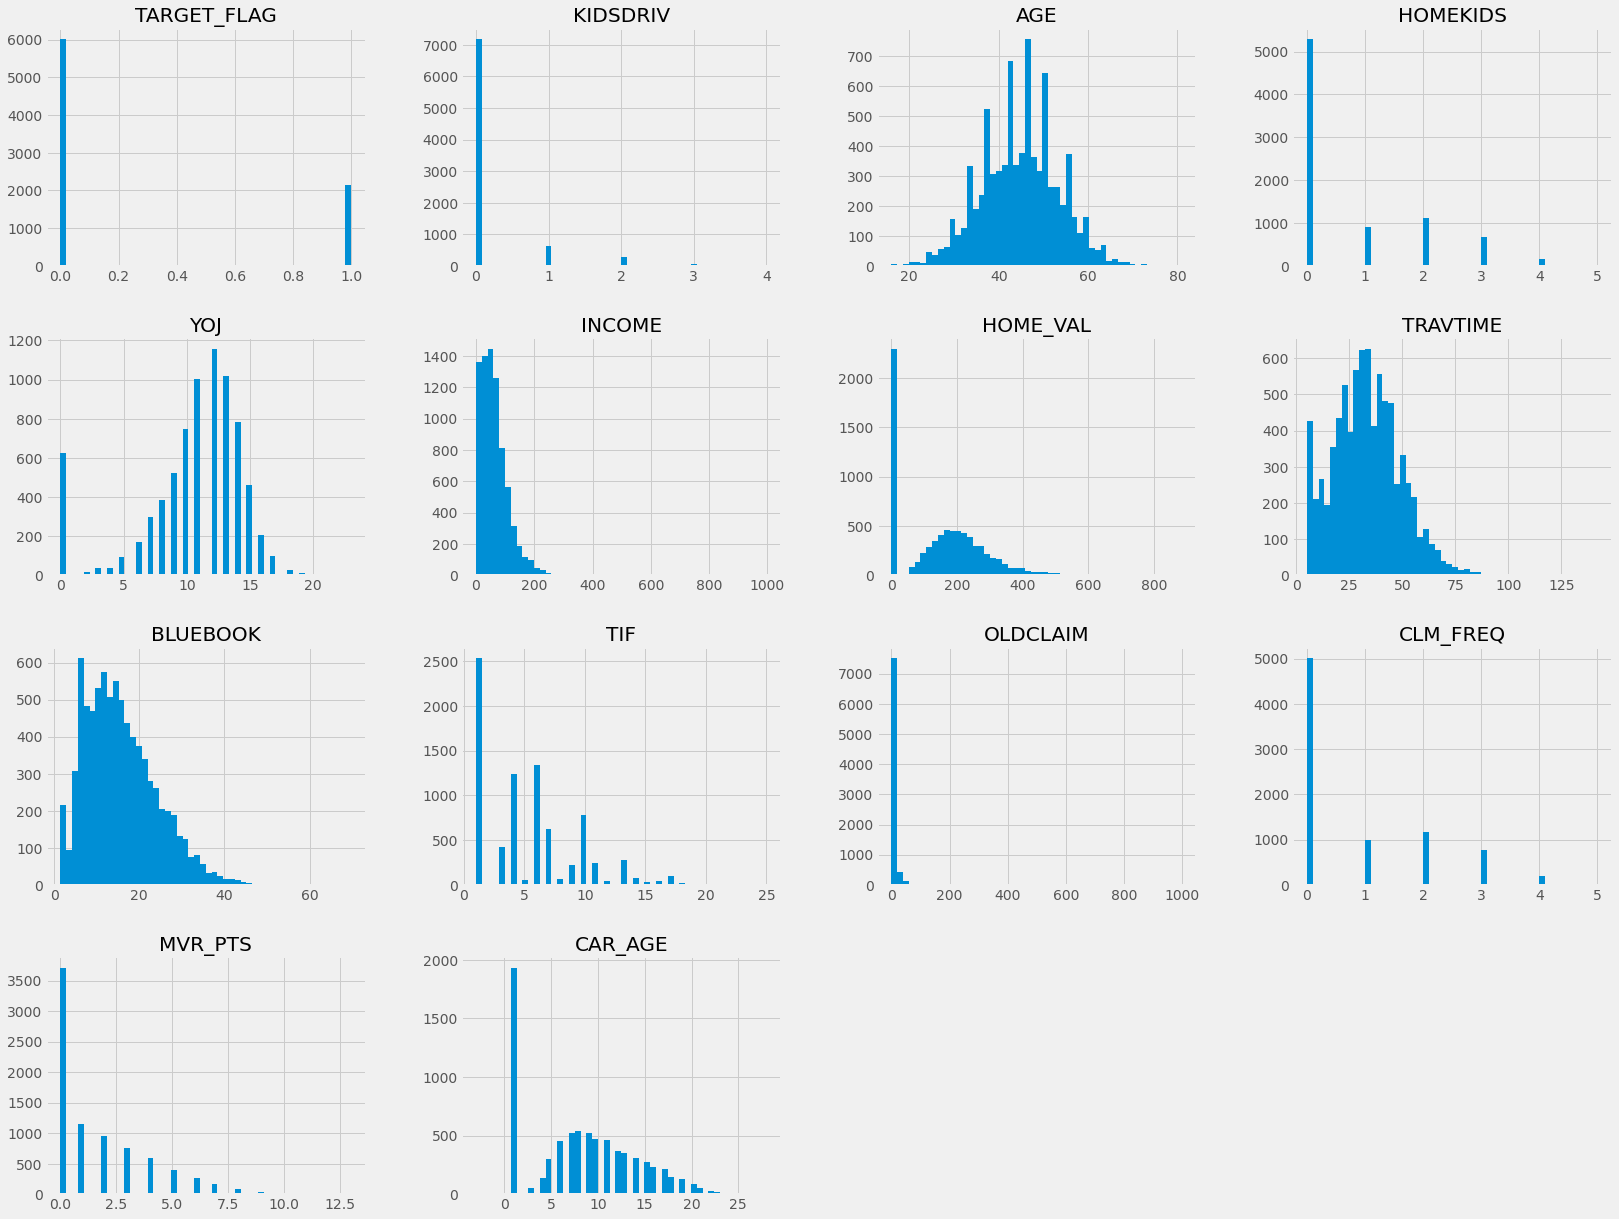

In [48]:
df.hist(bins= 50, figsize=(25,20))
plt.show()

Using the distribtuion of numerical feature, one can answer many questions : 

 - Firstly, the datas look really clean as only few outliers are present in the dataset (negative number of claims, age lower than legal driving age or age bigger than 100 for drivers etc, only the car age of -3 ...) : we need to clean it as this step is quite important before modelling (There is also an old claim going to $999K which sounds a lot, need to clean it).
 
 - We confirm what features might be discrete (number of kids) or continuous (age, travel time..) and their distribution.
 - We see that no features seems to have large tails and this can be really important for our algorithm to converge to good estimators. 
 - Features are not on on the same scale ( the travel time goes from 0 to 143 whereas the number of kids is no larger than 5). This is even worse regarding home value and income : the values can go to almost 1000. 
 - Many features have a lot of values at 0 like INCOME or HOMEVAL.
 
 
Concerning discrete features, lets see their frequency counts.

In [126]:
categorical_col = ['PARENT1', 'MSTATUS','SEX', 'EDUCATION', 'JOB', 'CAR_USE', 
                   'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY']

for col in categorical_col:
    print(col)
    print(df[col].value_counts()/len(df)*100, '\n') #print the frequency of each class for every categorical feature

PARENT1
No     86.803088
Yes    13.196912
Name: PARENT1, dtype: float64 

MSTATUS
Yes     59.968141
z_No    40.031859
Name: MSTATUS, dtype: float64 

SEX
z_F    53.608626
M      46.391374
Name: SEX, dtype: float64 

EDUCATION
z_High School    28.550423
Bachelors        27.472124
Masters          20.316138
<High School     14.740841
PhD               8.920475
Name: EDUCATION, dtype: float64 

JOB
z_Blue Collar    22.362456
Clerical         15.574072
Professional     13.687048
Manager          12.106360
Lawyer           10.231589
Student           8.724421
Home Maker        7.854430
Doctor            3.014336
Name: JOB, dtype: float64 

CAR_USE
Private       62.88445
Commercial    37.11555
Name: CAR_USE, dtype: float64 

CAR_TYPE
z_SUV          28.109300
Minivan        26.283544
Pickup         17.019973
Sports Car     11.113834
Van             9.190050
Panel Truck     8.283299
Name: CAR_TYPE, dtype: float64 

RED_CAR
no     70.861414
yes    29.138586
Name: RED_CAR, dtype: float64 

REVOK

Here we can see the data can be considered as balanced for features like sex, married status etc... It also looks like we can consider every class as well represented (excluding the doctor class [3%] for the JOB feature). We can therefore interpret results as significant for every classes of our features. 

As there is a lot of binary categorical data, we convert them easily to numerical features so we can use them for correlation calculations. We won't use LabelEncoder here as we have few features to encode.

In [127]:
df['PARENT1']=df['PARENT1'].map({'No' : 0, 'Yes':1}) #this function maps the answer 'No' to 0 and 'Yes' to 1.
df['MSTATUS']=df['MSTATUS'].map({'z_No' : 0, 'Yes':1})
df['SEX']=df['SEX'].map({'M' : 0, 'z_F':1})
df['RED_CAR']=df['RED_CAR'].map({'no' : 0, 'yes':1})
df['REVOKED']=df['REVOKED'].map({'No' : 0, 'Yes':1})
df['URBANICITY']=df['URBANICITY'].map({'Highly Urban/ Urban' : 0, 'z_Highly Rural/ Rural':1})
df['CAR_USE']=df['CAR_USE'].map({'Private' : 0, 'Commercial':1})



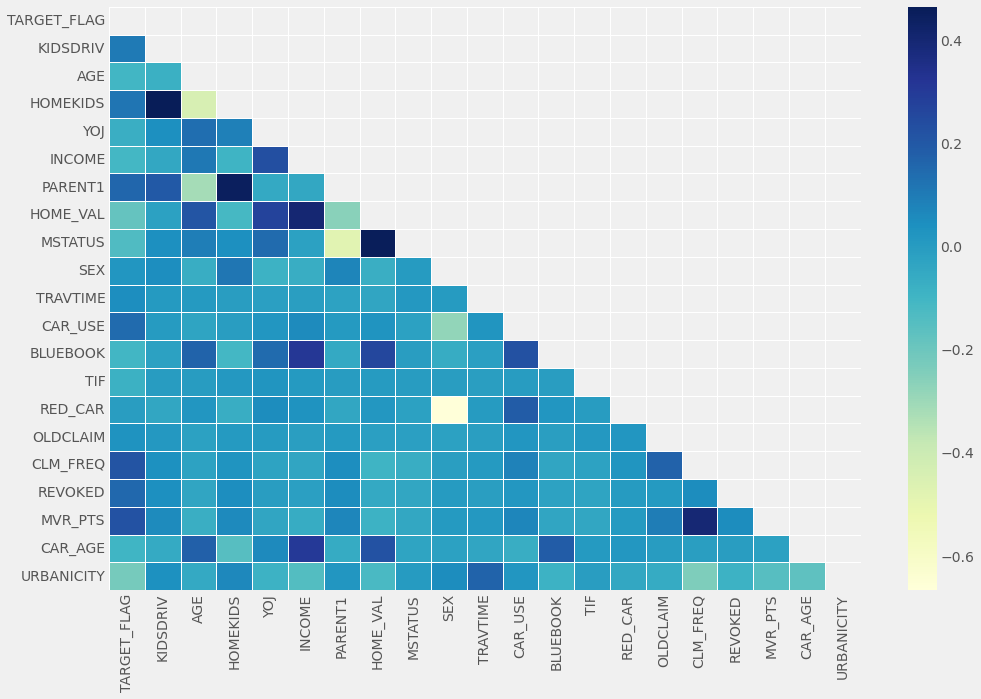

In [128]:
corr=df.corr() #compute correlations
#corr["TARGET_FLAG"].sort_values(ascending=False) #sort according to correlation with the target

fig, ax = plt.subplots(figsize=(15,10))   
mask = np.triu(np.ones_like(corr, dtype = bool)) #mask the symetric
sns.heatmap(corr,cmap='YlGnBu',linewidths=0.5, ax=ax, mask=mask)
plt.show()


The correlation heatmap helps us understanding better the linear relation between features and the target. Here we can see that there is little correlation between features (from -0.6 to 0.46). The max value are obtained for:
- HOMEKDS and KIDSDRIV (0.46) which make sens as an increase in the number of kids is a potential increase of kids driving your car.
- REDCAR and SEX (-0.66) which means that you are less likely to drive a red car as a woman according to our portfolio. 

The real point here is about the small "intercorrelation" between variables : the dataset is not full of redundant features that express the same information and we can keep all of them, or at least study all the relations to target before feature selection.

In [129]:
corr["TARGET_FLAG"].sort_values(ascending=False)


TARGET_FLAG    1.000000
MVR_PTS        0.219197
CLM_FREQ       0.216196
PARENT1        0.157622
REVOKED        0.151939
CAR_USE        0.142674
HOMEKIDS       0.115621
KIDSDRIV       0.103668
TRAVTIME       0.048368
OLDCLAIM       0.031704
SEX            0.021079
RED_CAR       -0.006947
YOJ           -0.070512
TIF           -0.082370
CAR_AGE       -0.100651
AGE           -0.103217
BLUEBOOK      -0.103383
INCOME        -0.106406
MSTATUS       -0.135125
HOME_VAL      -0.183737
URBANICITY    -0.224251
Name: TARGET_FLAG, dtype: float64

Studying such metrics helps us to confirm theoritical effect (longer drives, richest people are safer, younger take more riks...). The correlations can be interpreted as follows: 
 - losing licences points and having higher claim frequencies is likely to make a policyholder riskier
 - having kids driving makes your car more involved in crash accident.
 - sex and color of the car have little to no impact, just as if your car is for commercial purpose (not only private).
 - your age, the value of your car, your status (married or not), your income are likely to make you less involved in car accident 
 - drivers in rural zone are likely to have less accidents.

Regarding correlations, the most important (in terms of linear impact on the target) features seems to be MVR_PTS, CLM_FREQ,     PARENT1,        REVOKED, HOME_VAL and URBANICITY.


However, one must keep in mind that those correlations are quite small here and wonder wether or not is can be considered as significant. 

We might exclude from the study the following features : SEX, RED_CAR, OLDCLAIM (the amount has not any effect in opposite to the frequency of older claims). 


In [ ]:
feature_to_drop = ['SEX', 'RED_CAR', 'OLDCLAIM']

Concerning the categorical features left (that are multiclasses), we are going to study the distribution of TARGET_FLAG  according to their values.

Distribution of target w.r.t EDUCATION


<AxesSubplot:xlabel='TARGET_FLAG', ylabel='Count'>

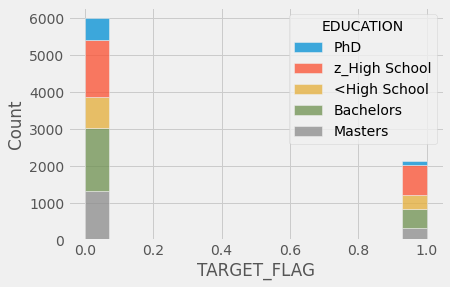

In [142]:
print('Distribution of target w.r.t {}'.format('EDUCATION'))
sns.histplot(x='TARGET_FLAG',data=df, hue='EDUCATION' , multiple="stack")

 People with high school level of education seems to be involved in more crashes than bachelors even though there represents the same share of people in the dataset (27%). We might want to dig in when modelling. 

In [181]:
for education in df['EDUCATION'].unique(): #for loop on values of EDUCATION
    print('For the "{}" education class, the share of individuals involved in crash accidents is : {:.2%}'.format(education,
        len(df.loc[(df['EDUCATION']==education) & (df['TARGET_FLAG']==1)])/len(df.loc[(df['EDUCATION']==education)])))

For the "PhD" education class, the share of individuals involved in crash accidents is : 17.17%
For the "z_High School" education class, the share of individuals involved in crash accidents is : 34.03%
For the "<High School" education class, the share of individuals involved in crash accidents is : 32.00%
For the "Bachelors" education class, the share of individuals involved in crash accidents is : 23.33%
For the "Masters" education class, the share of individuals involved in crash accidents is : 19.72%


In [176]:
len(df.loc[df['TARGET_FLAG']==1])/len(df) #share of crash incident among all individuals

0.2638157088592084

Here we can clearly see that, regarding your education level, there is more or less risk of beeing involved in a crash accident. For example, people with a PhD level might drive more safely as 17% of them only asre involved in crashes (vs 26% on average).

We could do the same remark regarding car types (SUV vs Minivan drivers for example) and even JOB.

Distribution of target w.r.t CAR_TYPE


<AxesSubplot:xlabel='TARGET_FLAG', ylabel='Count'>

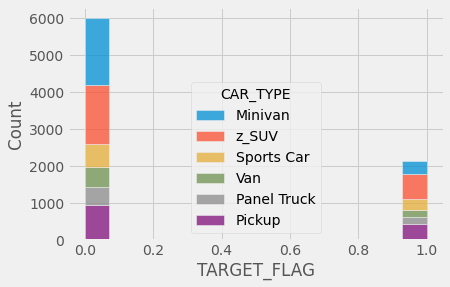

In [140]:
print('Distribution of target w.r.t {}'.format('CAR_TYPE'))
sns.histplot(x='TARGET_FLAG',data=df, hue='CAR_TYPE' , multiple="stack")


Distribution of target w.r.t JOB


<AxesSubplot:xlabel='TARGET_FLAG', ylabel='Count'>

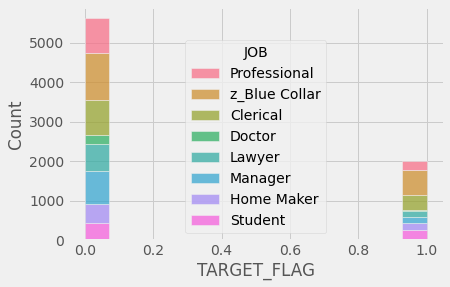

In [143]:
print('Distribution of target w.r.t {}'.format('JOB'))
sns.histplot(x='TARGET_FLAG',data=df, hue='JOB' , multiple="stack")

## Train/Test split

At this level, we can separate the dataset into train and test (or validation set before deploying our model on the test.csv file) and make sure to put the test aside for the evaluation of our model. We will thus avoid any source of $ \textit{data leakage} $ and we will concentrate on the relations between variables on a dataset with no test data. We also remind us of the data processing made so far.

In [206]:
df = data.copy() ##redo everything from starting point, to be sure we have the good initial database
df=df.drop(['TARGET_AMT'], axis=1)

convert_to_float=['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
for col in convert_to_float:
    df[col]= df[col].str.replace(',','.').str.replace('$','').astype('float64')
    #replace , by . and $ by empty string so the conversion work
    
df['PARENT1']=df['PARENT1'].map({'No' : 0, 'Yes':1}) #this function maps the answer 'No' to 0 and 'Yes' to 1.
df['MSTATUS']=df['MSTATUS'].map({'z_No' : 0, 'Yes':1})
df['SEX']=df['SEX'].map({'M' : 0, 'z_F':1})
df['RED_CAR']=df['RED_CAR'].map({'no' : 0, 'yes':1})
df['REVOKED']=df['REVOKED'].map({'No' : 0, 'Yes':1})
df['URBANICITY']=df['URBANICITY'].map({'Highly Urban/ Urban' : 0, 'z_Highly Rural/ Rural':1})
df['CAR_USE']=df['CAR_USE'].map({'Private' : 0, 'Commercial':1})

feature_to_drop = ['SEX', 'RED_CAR', 'OLDCLAIM', 'INDEX']

df=df.drop(feature_to_drop, axis=1)
    

/tmp/ipykernel_6821/1248967209.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col]= df[col].str.replace(',','.').str.replace('$','').astype('float64')


In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8161 entries, 0 to 8160
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   TARGET_FLAG  8161 non-null   int64  
 1   KIDSDRIV     8161 non-null   int64  
 2   AGE          8155 non-null   float64
 3   HOMEKIDS     8161 non-null   int64  
 4   YOJ          7707 non-null   float64
 5   INCOME       7716 non-null   float64
 6   PARENT1      8161 non-null   int64  
 7   HOME_VAL     7697 non-null   float64
 8   MSTATUS      8161 non-null   int64  
 9   EDUCATION    8161 non-null   object 
 10  JOB          7635 non-null   object 
 11  TRAVTIME     8161 non-null   int64  
 12  CAR_USE      8161 non-null   int64  
 13  BLUEBOOK     8161 non-null   float64
 14  TIF          8161 non-null   int64  
 15  CAR_TYPE     8161 non-null   object 
 16  CLM_FREQ     8161 non-null   int64  
 17  REVOKED      8161 non-null   int64  
 18  MVR_PTS      8161 non-null   int64  
 19  CAR_AG

Since class 0 is over-represented for the target variable,  we risk introducing a significant sampling bias if we randomly split the dataset. We therefore use StratifiedShuffleSplit to ensure that the test is representative of the whole dataset: 

In [196]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) #so the shares of 0 and 1 is kept when splitting

for train_index, test_index in split.split(df, df["TARGET_FLAG"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]


In [200]:
print("Test Set")
print(strat_test_set["TARGET_FLAG"].value_counts() / len(strat_test_set)*100)
print("Dataset")
print(df['TARGET_FLAG'].value_counts()/ len(df)*100)

Test Set
0    73.606859
1    26.393141
Name: TARGET_FLAG, dtype: float64
Dataset
0    73.618429
1    26.381571
Name: TARGET_FLAG, dtype: float64


Both sets look representative of the target flag distribution.

In [201]:
#we copy the datasets so we can work on them:
df_train=strat_train_set.copy()
df_test=strat_test_set.copy()

# Data preprocessing

## Data Cleaning

We separate the features from the labels, as we don't necessarily want to apply the same transformations to the predictive values and to our target.

In [204]:
X_train= df_train.drop("TARGET_FLAG", axis=1)
y_train = df_train["TARGET_FLAG"].copy()

### Outliers

Should the outliers be removed or replaced? Let's take a closer look at them first using a boxplot:

<AxesSubplot:>

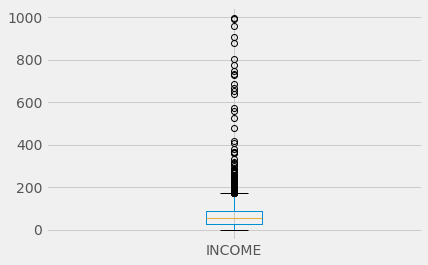

In [209]:
X_train.boxplot('INCOME')

Individuals outside 1.5IQR (interquartile range: Q3-Q1) are considered outliers, we can calculate to which part of the dataframe this corresponds:œ

In [225]:
def outlier_col(df,col):
    Q3 = df[col].quantile(0.75) 
    Q1= df[col].quantile(0.25)
    IQR = Q3 - Q1

    upper_bound= Q3+1.3*IQR
    lower_bound = Q1- 1.5*IQR
    part=len(df.loc[(df[col]<lower_bound) |(df[col]> upper_bound)])/df[col].notnull().sum()
    print("Share of outliers for " + col +" : {:.2%}".format(part))

outlier_col(X_train,'INCOME')

Share of outliers for INCOME : 4.50%


We can for example see here that some Income are surpisingly high. Regardind their numbers, one can also wonder about the nature of the outliers, if some of them seem to be isolated errors, it may be that the presence of these outliers is an indicator of the volatility of the real data, hence the interest to conduct further research to identify the source of the outliers.

Since I don't have control over the data set, I prefer to keep the information from other features, and will not remove the outliers.


Instead, we opt for a winsorization method consisting in limiting their impact by crushing a proportion $\alpha$ of the extreme values on the quantiles of order $\frac{\alpha}{2}$ and $1-\frac{\alpha}{2}$.

We will opt for $\alpha=0.05$.

In [245]:
def winsorizing(col):
    return scipy.stats.mstats.winsorize(col, limits=0.05)

def outlier_cleaner(df):
    return df.apply(winsorizing, axis=0)

#creating a class so we might put it in a pipeline later
#and test a model with and without winsorization

from sklearn.base import BaseEstimator, TransformerMixin

class Outlier(BaseEstimator, TransformerMixin):
    def __init__(self, winsorizing = True): 
        self.winsorizing = winsorizing
    
    def fit(self, X, y=None):
         return self # nothing else to do
    
    def transform(self, X):
        if winsorizing:
            return outlier_cleaner(X)
        else:
            return X

outlier=Outlier()

outlier.fit_transform(X_train[['INCOME', 'CAR_AGE']]).describe()


,INCOME,CAR_AGE
count,6157.000000,6120.000000
mean,64.505556,8.420261
std,61.373811,5.664867
min,0.000000,1.000000
25%,28.538000,3.000000
50%,54.307000,8.000000
75%,86.847000,12.000000
max,997.000000,28.000000


It looks like winsorized data made the car age look more natural (no negative data), however the income did not move and this conforts us in thinking the income outliers might be useful

In [251]:
X_train[['INCOME', 'CAR_AGE']]=outlier.fit_transform(X_train[['INCOME', 'CAR_AGE']])

### Missing values

We noticed before that each variable had few missing values, what happens if we drop the set of policyholders for which some variables are missing? 

In [255]:
print("Number of policyholders dropped: " + '{}'.format(len(X_train)-len(X_train.dropna(axis=0))))
print("Kept share : " +"{:.2%}".format(len(X_train.dropna(axis=0))/len(X_train)))

Number of policyholders dropped: 1697
Kept share : 74.00%


As we thought, we lose too many entries by this method. We need to think of one more adapted to our datasets. We could for example impute the missing values with various strategies such as replacing NaN by the mean, median or the mode ! However  it is hard to know what imputing methods makes the more sense. Focusing on HOME_VAL for example : one might wonder wether the best is to replace a missing value by the average income or by a 0 as it simply means the policy holders skipped this row if he is not the owner. Same remark for JOB (does 0 imply no JOB? or do not enter in the categories?  ...) To keep things simple here and just to illustrate this imputation step, we will impute every NaN for numerical features by their median and by the most frequent class for categorical data. 

However, this choice is not optimal and we could discuss a lot more complexe strategies : for example we could fill the mssing income of an individual with the average income in its education level class (assuming there is a strong link between those features) etc...

In [267]:
X_train.loc[X_train.index==1421] #example of a NaN JOB with a PhD education level and high income
#makes it hard to interperet missing values

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
1421,0,50.0,0,12.0,218.705,0,0.0,0,PhD,NaN,47,1,28.37,14,Panel Truck,2,0,8,15.0,0


In [261]:
X_train.dtypes

KIDSDRIV        int64
AGE           float64
HOMEKIDS        int64
YOJ           float64
INCOME        float64
PARENT1         int64
HOME_VAL      float64
MSTATUS         int64
EDUCATION      object
JOB            object
TRAVTIME        int64
CAR_USE         int64
BLUEBOOK      float64
TIF             int64
CAR_TYPE       object
CLM_FREQ        int64
REVOKED         int64
MVR_PTS         int64
CAR_AGE       float64
URBANICITY      int64
dtype: object

In [262]:
X_train.columns

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',
       'MSTATUS', 'EDUCATION', 'JOB', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF',
       'CAR_TYPE', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY'],
      dtype='object')

In [392]:
numerical_features= ['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',
       'MSTATUS', 'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'URBANICITY']
categorical_features = ['EDUCATION', 'JOB', 'CAR_TYPE']

In [376]:
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(missing_values=np.nan, strategy='median') #load median imputer 
cate_imputer = SimpleImputer(missing_values=np.nan, strategy ='most_frequent') #load most frequent imputer for categorical data

In [415]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [455]:
imputing_pipeline = ColumnTransformer([
    ("num_pipeline", num_imputer, numerical_features),
    ("cat_pipeline", cate_imputer, categorical_features)
])

In [456]:
try_pipeline = pd.DataFrame(imputing_pipeline.fit_transform(X_train),
                            columns =numerical_features + categorical_features)

In [457]:
try_pipeline.isnull().sum() #check if imputation worked, seems ok ! 

KIDSDRIV      0
AGE           0
HOMEKIDS      0
YOJ           0
INCOME        0
PARENT1       0
HOME_VAL      0
MSTATUS       0
TRAVTIME      0
CAR_USE       0
BLUEBOOK      0
TIF           0
CLM_FREQ      0
REVOKED       0
MVR_PTS       0
CAR_AGE       0
URBANICITY    0
EDUCATION     0
JOB           0
CAR_TYPE      0
dtype: int64

### Encoding categorical data

We now need to encode categorical data. We might use OrdinalEncoder for Education level to express the theoritcal effect the higher the education level the less risky you are considered. This is possible as we can ordonate these categories and keep a notion of "distance" : Master will be near of PhD and far from <HighSchool. However, I found it difficult to do the same with JOB and CarType so we will just OneHotEncode them, hoping not adding too many features. 

In [446]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories=[['<High School', 'z_High School','Bachelors', 'Masters', 'PhD']])
#we precise the order we want in the categories argument

In [451]:
ordinal_encoder.fit_transform(X_train[['EDUCATION']])[:5]#to compare and be sure we have the same order : ok masters is the 4th lvl encoded as 3,
#PhD 4, high school 1, looks good

array([[3.],
       [4.],
       [1.],
       [4.],
       [1.]])

In [450]:
X_train['EDUCATION'].head() #to compare and be sure we have the same order : ok masters is the 4th lvl encoded as 3,
#PhD 4, high school 1, looks good

1874          Masters
1421              PhD
435     z_High School
5008              PhD
6572    z_High School
Name: EDUCATION, dtype: object

In [454]:
#OneHotEncoding for the other categorical features : 
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder()

In [562]:
pd.DataFrame(oh_encoder.fit_transform(X_train[['JOB']]).toarray())

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
6523,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6525,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [527]:
#We might now make the two transformation in one step only for every categorical features by using a pipeline:
cate_encoding = ColumnTransformer([
    ("ordinal_pipeline", ordinal_encoder, ['EDUCATION']),
    ("oh_pipeline", oh_encoder, ['JOB','CAR_TYPE'])
])


In [529]:
pd.DataFrame(cate_encoding.fit_transform(X_train).toarray()) #we obtain the right number of columns 
#9 for JOBS, 6 for car types and 1 for EDUCATION and quick checks confirms the encoding worked properly.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6524,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6525,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6526,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Features scaling and summary of transformations

Now, we need to rescale our future so we can get rid of the many 0 in some distributions and reduce the effect of bigger values (income or home value vs Age..) so the algorithms will pay the right amount of attention to all features.

In [601]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler() 

In [602]:
#impute missing values for both #numerical and categorical data
X_train_imputed = pd.DataFrame(imputing_pipeline.fit_transform(X_train),
                            columns =numerical_features + categorical_features) 

# encode categorical features with the previous methods (OH for JOB and CARTYPE, Ordinal for EDUCATION)
X_train_catencoded =  pd.DataFrame(cate_encoding.fit_transform(X_train_imputed).toarray(),
                             columns =['EDUCATION', 'Clerical', 'Doctor', 'Home Maker', 'Lawyer', 'Manager', 
                                       'Professional','Student', 'z_Blue Collar','Minivan', 'Panel Truck',
                                       'Pickup', 'Sports Car', 'Van', 'z_SUV'])

#continous features needing scaling.
to_scale=['AGE', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'CAR_AGE']
#scale continuous features
num_not_scaled =list(set(numerical_features)-set(to_scale)) #non scaled features
X_train_numscaled=pd.DataFrame(scaler.fit_transform(X_train_imputed[to_scale]), columns = to_scale) 
X_train_notscaled = X_train_imputed[num_not_scaled]

#now lets gather everything in our final dataset.
X_prepared = pd.concat([X_train_numscaled, X_train_notscaled, X_train_catencoded], axis=1)


In [612]:
X_prepared.info() #check the columns, number of entries...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AGE            6528 non-null   float64
 1   INCOME         6528 non-null   float64
 2   HOME_VAL       6528 non-null   float64
 3   TRAVTIME       6528 non-null   float64
 4   BLUEBOOK       6528 non-null   float64
 5   CAR_AGE        6528 non-null   float64
 6   HOMEKIDS       6528 non-null   object 
 7   KIDSDRIV       6528 non-null   object 
 8   TIF            6528 non-null   object 
 9   CAR_USE        6528 non-null   object 
 10  MSTATUS        6528 non-null   object 
 11  YOJ            6528 non-null   object 
 12  URBANICITY     6528 non-null   object 
 13  PARENT1        6528 non-null   object 
 14  REVOKED        6528 non-null   object 
 15  CLM_FREQ       6528 non-null   object 
 16  MVR_PTS        6528 non-null   object 
 17  EDUCATION      6528 non-null   float64
 18  Clerical

In [611]:
X_prepared.describe() #make sure everything is all right (features distribution etc)

,AGE,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,CAR_AGE,EDUCATION,Clerical,Doctor,Home Maker,...,Manager,Professional,Student,z_Blue Collar,Minivan,Panel Truck,Pickup,Sports Car,Van,z_SUV
count,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6.528000e+03,6528.000000,6528.000000,6528.000000,6528.000000,...,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000
mean,1.589143e-16,-3.374207e-17,-6.149765e-17,8.381095e-17,-1.330635e-16,-6.748414e-17,1.808517,0.155637,0.031556,0.079350,...,0.121936,0.135263,0.087316,0.287224,0.267004,0.080882,0.169424,0.110447,0.093597,0.278646
std,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.000077e+00,1.183530,0.362539,0.174829,0.270306,...,0.327237,0.342031,0.282319,0.452502,0.442428,0.272675,0.375155,0.313470,0.291289,0.448367
min,-3.337393e+00,-1.071752e+00,-1.232583e+00,-1.781852e+00,-1.690748e+00,-1.347922e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.784583e-01,-5.626334e-01,-1.232583e+00,-7.196267e-01,-7.587294e-01,-8.010231e-01,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.517681e-02,-1.612667e-01,4.136391e-02,-3.230438e-02,-1.509434e-01,-7.182511e-02,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.088119e-01,3.361328e-01,6.200584e-01,6.550179e-01,6.099855e-01,6.573729e-01,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,4.176987e+00,1.564347e+01,5.792382e+00,6.778435e+00,6.022631e+00,3.574165e+00,4.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


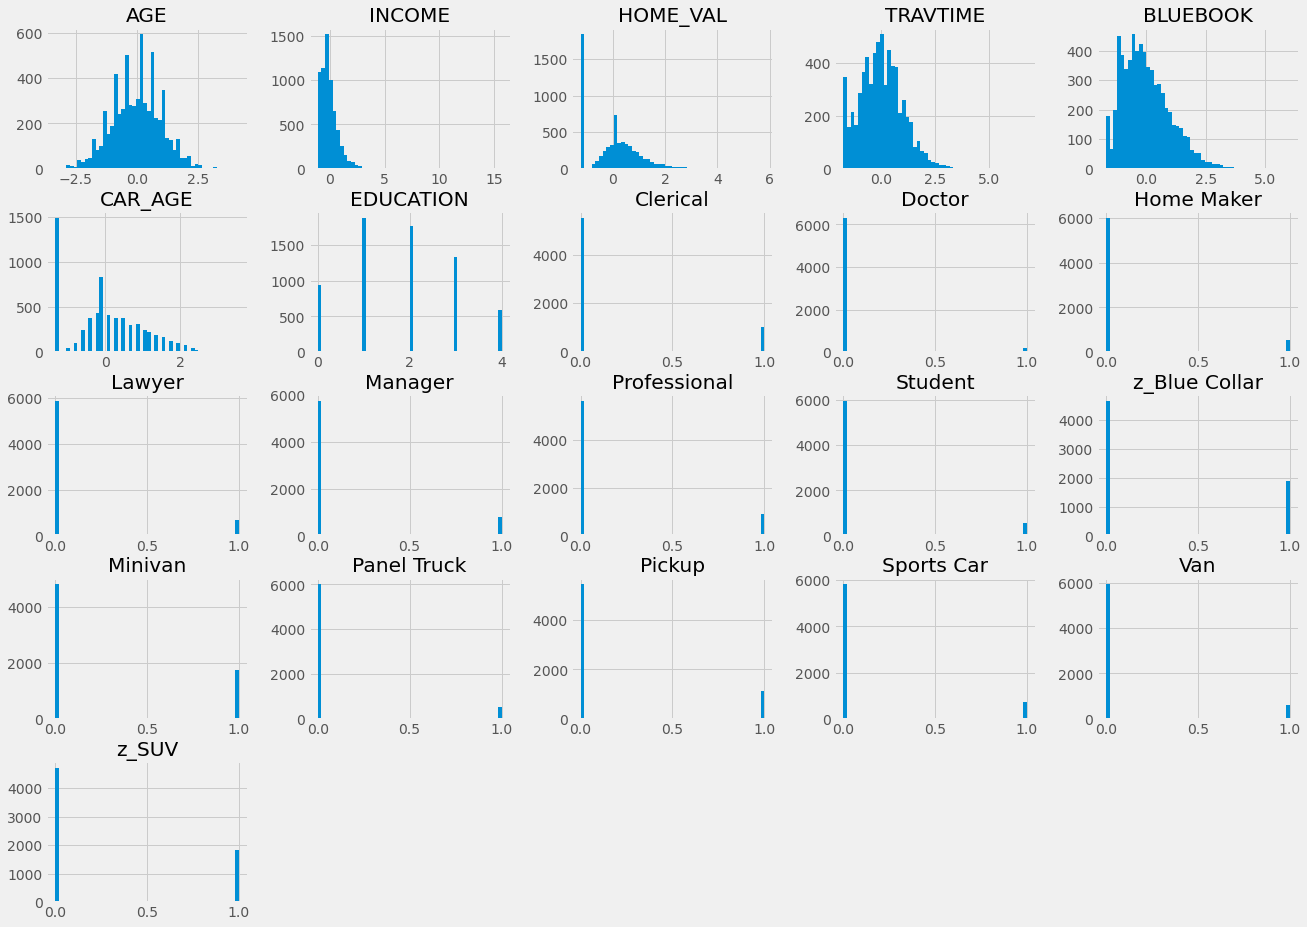

In [615]:
#plot distribution to make sure our features have better expected distribution
X_prepared.hist(bins=50, figsize=(20,15)) 
plt.show() 


After so much work on data exploration and processing, it looks like we are now ready to work on the classification task ! 

# Classification Task

## Benchmark Model 
Before embarking on the search for the best model, let us study a naive classification model that predicts that no individual will have a car accident  ($textit{i.e}$ classifies every entry as 0,). This is a naive and bad approach for an insurer, however it is used for comparison purposes.

In [617]:
class Never_default_Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [618]:
from sklearn.model_selection import cross_val_score
nd_clf = Never_default_Classifier()
cross_val_score(nd_clf, X_prepared, y_train, cv=3, scoring="accuracy")

array([0.73667279, 0.73897059, 0.73299632])

With this very naive and probably not very recommendable model, we reach an accuracy of more than 70%! This is simply because 30% of the policyholders have car crashes: predict that individuals won't have car accident an you will be right almost two third of the time. 

## Score to be preferred

Moreover, given the problem, we can think about which score to favour in our situation between accuracy, recall and precision. Given the results of the accuracy with the naive classifier, we will not privilege this measure because our data set is unbalanced in terms of class.


As we are working on an insurance claim problem, we can imagine that we wish to build an indicator for a team of experts wishing to facilitate the study of policyholders records. 
If the objective is to provide an indicator to a team of experts in order to warn them of the riskiest cases, we should favour the recall which measures the sensitivity of the model to recognise the positive class (potential accident here).

* Indeed, the most "serious" error here is the false negatives: we do not detect a person who is likely to have an accident and lose money by mispricing the risk (vs. false-positive, i.e. a person who is considered as riksy but who would eventually have no accident.


We could also use the F1 score which would take into account precision and recall, but we can say that it is not really serious if the precision score is not very high: if the precision is 30% and the recall 90%, the expert team would receive some false alarms and would check some "non-risky" files which is better than losing money by trusting a bad model. 

* Note: as the positive class is under-represented, we will also look at the ROC-AUC in addition to the recall/precision trade-off.


In [621]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import make_scorer # useful to pass score in argument of cross_val_score function

recall=make_scorer(recall_score)
precision=make_scorer(precision_score)
roc= make_scorer(roc_auc_score)
f1=make_scorer(f1_score)

## Model testing

We will draw up a shortlist of models to test and we will choose the most promising ones before optimizing briefly the parameters later on (as it not important in the assignement here). Basic models that are adapted to classification tasks are : 

- kNN 
- SVM 
- Logistic regression
- Decision Tree

State of the art shows that GLM is one of the most used model in the insurance field because of its interpretability. Here we will just rely on the power of ML for pure prediction (and try to exract some insight too !)
We will also try more powerful models such as RandomForest or XgBoost and will introduce a method to deal with our imbalanced data. 




In [619]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### SVM classifier

In [633]:
svm_clf=LinearSVC(random_state=1)
#train on training set to begin, naive approach with no parameter optimization
def get_score_train(model,X_prepared,y_train): 
    '''Function that computes the set of scores given a model and a set of data 
    (features + label)
    The function trains the model and uses the predictions from the train to evaluate the scores'''

    model.fit(X_prepared, y_train)
    y_pred = model.predict(X_prepared)
    print('Recall train :' + '{:.2%}'.format(recall_score(y_pred, y_train)))
    print('Precision train :' + '{:.2%}'.format(precision_score(y_pred, y_train)))
    print('ROC-AUC train :' + '{:.2%}'.format(roc_auc_score(y_pred, y_train)))

get_score_train(svm_clf,X_prepared,y_train) 
#fail to converge, won't take into account now but might need more iterations or regularization


Recall train :63.09%
Precision train :46.05%
ROC-AUC train :72.73%


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [663]:
#introduce now some cross_val on train set (5 folds here) 
from sklearn.model_selection import cross_val_score

def display_scores_df(model, X_prepared,y_train,cv):
    '''Function taking as argument a model, a dataset (features + label) 
    and the number of Folds for the cross_val'''
    
    scores_recall = cross_val_score(model, X_prepared, y_train, cv=cv, scoring=recall)
    scores_precision= cross_val_score(model, X_prepared, y_train, cv=cv, scoring=precision)
    scores_roc= cross_val_score(model, X_prepared, y_train, cv=cv, scoring=roc)
    df_score=pd.DataFrame({'Moyennes' : [scores_recall.mean(), scores_precision.mean(), scores_roc.mean()],
                          'Ecart Type': [scores_recall.std(), scores_precision.std(), scores_roc.std()] },
                        index=['Recall', 'Precision', 'ROC-AUC'])
    return df_score #dataframe for more readability 


resultats_svm_clf=display_scores_df(svm_clf,X_prepared,y_train,cv=5) 
resultats_svm_clf  
#models is not as good as before with cross_val evaluation that better etimate the generalization error

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages

,Moyennes,Ecart Type
Recall,0.401254,0.018770
Precision,0.646003,0.041847
ROC-AUC,0.660467,0.003686


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages

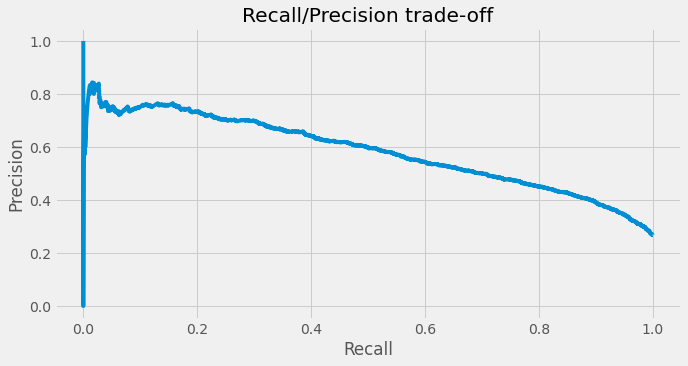

In [664]:
#might want to plot precision vs.recall 

from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(svm_clf, X_prepared, y_train, cv=10,
 method="decision_function") #10 folds so we have more points to plot 

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(10,5))
plt.title('Recall/Precision trade-off')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls, precisions)

This illustrates the recall/precision trade-off.
At this level we could consider setting a certain threshold to our model in order to obtain a higher recall (at the cost of a much lower precision as shown by the decreasing trend between recall and precision). 
We try other models first.

### KNN Classifier

In [675]:
knn_clf = KNeighborsClassifier(5)

print(get_score_train(knn_clf,X_prepared,y_train))
resultats_knn_clf=display_scores_df(knn_clf,X_prepared,y_train,cv=5) 
resultats_knn_clf #worse results than SVM  !

Recall train :73.78%
Precision train :42.16%
ROC-AUC train :77.91%
None


,Moyennes,Ecart Type
Recall,0.254929,0.027065
Precision,0.491323,0.023142
ROC-AUC,0.580336,0.012142


### Logistic Regression

In [648]:
log_reg = LogisticRegression(random_state=0, max_iter=1000) #for convergence purposes, use max iter

print(get_score_train(log_reg,X_prepared,y_train))
resultats_log_reg=display_scores_df(log_reg,X_prepared,y_train,cv=5) 
resultats_log_reg #at least as performant as SVM, better than naive KNN

Recall train :65.40%
Precision train :41.06%
ROC-AUC train :73.38%
None


,Moyennes,Ecart Type
Recall,0.410598,0.035321
Precision,0.644187,0.028504
ROC-AUC,0.664829,0.018985


An additional advantage of logistic regression is that a probability metric can be accessed through the predict_proba method. 

In [649]:
log_reg.fit(X_prepared, y_train)
log_reg.predict_proba(X_prepared)

array([[0.8445668 , 0.1554332 ],
       [0.57589201, 0.42410799],
       [0.86895658, 0.13104342],
       ...,
       [0.70572273, 0.29427727],
       [0.41751973, 0.58248027],
       [0.85578406, 0.14421594]])

In [650]:
print(log_reg.predict(X_prepared)[0])
print(log_reg.predict(X_prepared)[-2])

0
1


Here we see that the first and the second to last individuals have respectively a proba of 0.84 (>0.5) and 0.42(<0.5) to belong to class 0. They are thus classified respectively in class 0 and 1. Access to this probability may be an interesting metric for a team in charge of studying the risk of an individual for auto insurance.

### RandomForest 

Now we try more popular ML models used in insurance.

In [652]:
rnd_clf=RandomForestClassifier(random_state=1)
print(get_score_train(rnd_clf,X_prepared,y_train))

Recall train :100.00%
Precision train :99.94%
ROC-AUC train :99.99%
None


Metrics show really high performance !! Let's see with cross val.

In [654]:
resultats_rnd_clf=display_scores_df(rnd_clf,X_prepared,y_train,cv=5) 
resultats_rnd_clf

,Moyennes,Ecart Type
Recall,0.329862,0.028891
Precision,0.673635,0.024452
ROC-AUC,0.636425,0.015103


Indeed, we did not find a perfect model. The difference between the results on the train and those obtained by cross_validation indicates rather a strong overfitting phenomenon, it would be necessary to regularize the model and to carry out feature selection later.

### XGBoost 

In [661]:
xgb_clf = xgb.XGBClassifier(eval_metric= 'logloss',use_label_encoder=False)
print(get_score_train(xgb_clf,X_prepared.astype('float64'),y_train))
resultats_xgb_clf=display_scores_df(xgb_clf,X_prepared.astype('float64'),y_train,cv=5) 
resultats_xgb_clf
# same overfitting phenomenon

Recall train :98.76%
Precision train :92.28%
ROC-AUC train :98.03%
None


,Moyennes,Ecart Type
Recall,0.455315,0.025934
Precision,0.596867,0.012955
ROC-AUC,0.672622,0.012257


### Performance summary of our shortlist 

In [677]:
print('SVM: \n' ,resultats_svm_clf)
print('\n KNN: \n' ,resultats_knn_clf)
print('\n Régression logisitque : \n' ,resultats_log_reg)
print('\n RandomForest Classifier ; \n', resultats_rnd_clf)
print('\n XGBoost Classifier \n' , resultats_xgb_clf)

SVM: 
            Moyennes  Ecart Type
Recall     0.401254    0.018770
Precision  0.646003    0.041847
ROC-AUC    0.660467    0.003686

 KNN: 
            Moyennes  Ecart Type
Recall     0.254929    0.027065
Precision  0.491323    0.023142
ROC-AUC    0.580336    0.012142

 Régression logisitque : 
            Moyennes  Ecart Type
Recall     0.410598    0.035321
Precision  0.644187    0.028504
ROC-AUC    0.664829    0.018985

 RandomForest Classifier ; 
            Moyennes  Ecart Type
Recall     0.329862    0.028891
Precision  0.673635    0.024452
ROC-AUC    0.636425    0.015103

 XGBoost Classifier 
            Moyennes  Ecart Type
Recall     0.455315    0.025934
Precision  0.596867    0.012955
ROC-AUC    0.672622    0.012257


Accord to the metrics we decided to use, the best models so far are XGBoost and Logistic Regression. We chose here to briefly fine_tune XgBoost to show the general method of fine_tuning parameters and feature selection.

## Fine Tuning and Feature selection

### Best XGBoost Parameters

In [678]:
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import GridSearchCV

We first use a randomized search that will explore some parameters combination, this will help us reducing the space of potential parameters. 

In [694]:
xgb_clf = xgb.XGBClassifier()

#param_distribution allows us to give a space of hyperparameters to try with CV
random_search=RandomizedSearchCV(xgb_clf, param_distributions={'objective':['logloss'],'n_estimators': [100, 200, 350, 600],
                                              'max_features': ['sqrt', 'log2'],'max_depth' : [4, 6, 8, 10],
                                              'learning_rate': [0.1, 0.05],'criterion' :['gini', 'entropy'],
                                              'bootstrap' : [True, False]},
                                               verbose=2, random_state=1, n_jobs = -1, cv=3, scoring=recall,
                                 n_iter=5)

#n_iter tells to try only 5 combinations (so the computation won't be too loong)

In [695]:
random_search.fit(X_prepared.astype('float64'),y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is depreca

[14:00:20] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:00:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END bootstrap=True, criterion=gini, learning_rate=0.05, max_depth=4, max_features=sqrt, n_estimators=350, objective=binary:logistic; total time=10.1min
[14:10:25] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_ms

[14:00:21] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:00:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END bootstrap=True, criterion=gini, learning_rate=0.05, max_depth=4, max_features=sqrt, n_estimators=350, objective=binary:logistic; total time=10.0min
[14:10:20] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_ms

[14:00:20] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:00:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END bootstrap=False, criterion=gini, learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=200, objective=binary:logistic; total time=22.7min
[14:23:02] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bi

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_ms

[14:00:21] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:00:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END bootstrap=False, criterion=gini, learning_rate=0.05, max_depth=10, max_features=sqrt, n_estimators=200, objective=binary:logistic; total time=23.6min
[14:23:58] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bi

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:41:58] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:41:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [696]:
random_search.best_params_ #show us the best parameters

{'objective': 'binary:logistic',
 'n_estimators': 350,
 'max_features': 'sqrt',
 'max_depth': 4,
 'learning_rate': 0.05,
 'criterion': 'gini',
 'bootstrap': True}

We may now reduce our space of parameters and only use a subspace around the best parameters. We now use a  Grid Search method that will try every possible combination. The following cell implement the grid search, however it was not runned to reduce time computation. We will here use the best param obtained through randomized search.

In [ ]:
param_grid ={'objective':['binary:logistic', 'logloss'],
             'n_estimators': [300,350,400,500],
             'max_features': [ 'sqrt'],
             'max_depth' : [5,10, 20],
             'learning_rate': [0.05,0.02, 0.01],
             'criterion': ['gini'],
             'bootstrap' : [True]} #define a subspace of parameters

grid_search = GridSearchCV(xgb_clf,param_grid, cv = 3, n_jobs = -1, scoring=recall)
grid_search.fit(X_prepared.astype('float64'), y_train)
print(grid_search.best_score_) #The best recall with fine-tuned parameters


In [699]:
best_xgb_clf= random_search.best_estimator_ #save the best model 

#Rsee the results: 
resultats_best_xgb_clf=display_scores_df(best_xgb_clf,X_prepared.astype('float64'),y_train,cv=3) 
resultats_best_xgb_clf

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:14] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:15] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:16] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:17] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:23] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:24] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:25] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:26] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:27] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:46:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Moyennes,Ecart Type
Recall,0.449477,0.032029
Precision,0.644750,0.024918
ROC-AUC,0.680523,0.017450


We see that using that much of calculation power did not really improve the metrics, let's reduce our number of features by feature selection.

### Best XGB classifier feature selection

We are now interested in extracting some insight. For example, the feature importance method allows us to know what features take the most important roles in the classification task, we use it to select a subsample of features.

[14:49:40] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:49:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

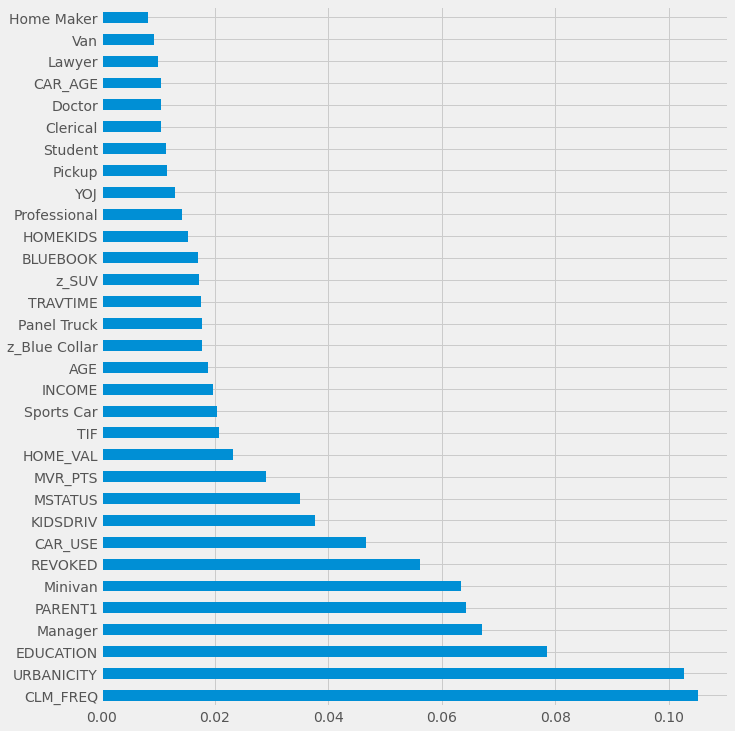

In [709]:
best_xgb_clf.fit(X_prepared.astype('float64'),y_train)
features_importances = pd.Series(best_xgb_clf.feature_importances_, index=X_prepared.columns).sort_values(ascending=False)
features_importances.plot(kind='barh', figsize=(10,12)) #use feature importance method and plot it

Here we see which features help the models classify best the policyholders ! Looks like the previous claims frequency, your education level , your driving zone (rural vs urban), your car use (private vs commercial), wether or not you have kids driving your car, married status etc... are a the most important features for our prediction. We also see that being a Manager and driving a Minivan might have a huge influence on our decision. However this feature importances don't tell us in which way a feature contributes to our decision and it belongs to us to interpet them.

In [710]:
#Let's keep the 12 first features for example
features=list(features_importances.index)[:12]

X_prepared_reduced = X_prepared[features].copy().astype('float64')


In [714]:
display_scores_df(best_xgb_clf,X_prepared_reduced,y_train,cv=5) 

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:12] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:13] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:14] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:15] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:16] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:17] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:17] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:18] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:19] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:20] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:22] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:23] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:24] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:25] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:55:27] WARNING: ../src/learner.cc:576: 
Parameters: { "bootstrap", "criterion", "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:55:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Moyennes,Ecart Type
Recall,0.391437,0.031751
Precision,0.600668,0.026885
ROC-AUC,0.649214,0.016944


This seems to help the precision a lot !! However, our goal on recall is here not achieved as it is even lower than before !

# Oversampling for imbalanced dataset 

We saw when exploring the dataset that our target was imbalanced with 3 times more 0 than 1. One way to deal with this situation is call oversampling : we will generates datas labeled as 1 with the SMOTE libraries (actually we could also undersample the 0 class but as we do not have that much data...).

In [721]:
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE # see https://imbalanced-learn.org/stable/ for documentation


In [734]:
y_train.value_counts() #see that the data is really imbalanced

0    4806
1    1722
Name: TARGET_FLAG, dtype: int64

In [732]:
over = SMOTE() #could controle the sampling parameter, by default in generate as many 1 than there are 0s.
over.fit_resample(X_prepared,y_train)[-1].value_counts() #we oversample it using SMOTE 
#obtain as many 0s as 1s. 

0    4806
1    4806
Name: TARGET_FLAG, dtype: int64

In [735]:
# define a pipeline and introduce the Over Sampling in it directly. 
steps = [('over', SMOTE()), ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1) #repeated stratified to be sure we have well represented classes
mean_recall_scores = cross_val_score(pipeline, X_prepared, y_train, scoring='recall', cv=cv, n_jobs=-1)
mean_precision_scores = cross_val_score(pipeline, X_prepared, y_train, scoring='precision', cv=cv, n_jobs=-1)
mean_roc_auc_scores=cross_val_score(pipeline, X_prepared, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

print('Mean Recall: %.3f' % np.mean(mean_recall_scores))
print('Mean Precision: %.3f' % np.mean(mean_precision_scores))
print('Mean Roc_Auc: %.3f' % np.mean(mean_roc_auc_scores))

Mean Recall: 0.754
Mean Precision: 0.479
Mean Roc_Auc: 0.805


This method definitely provides us better results ! We will keep this trained model for evaluation on test set.

In [739]:
parameters = {'model__C': np.logspace(-8, 8, 17, base=2)} # defining parameter space 
clf4 = GridSearchCV(pipeline, parameters, cv=cv) #using the cv defined before
clf4.fit(X_prepared, y_train)

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=1),
             estimator=Pipeline(steps=[('over', SMOTE()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': array([3.90625e-03, 7.81250e-03, 1.56250e-02, 3.12500e-02, 6.25000e-02,
       1.25000e-01, 2.50000e-01, 5.00000e-01, 1.00000e+00, 2.00000e+00,
       4.00000e+00, 8.00000e+00, 1.60000e+01, 3.20000e+01, 6.40000e+01,
       1.28000e+02, 2.56000e+02])})

In [740]:
print('Returned hyperparameter: {}'.format(clf4.best_params_))
print('Best classification recall in train is: {}'.format(clf4.best_score_))

Returned hyperparameter: {'model__C': 64.0}
Best classification recall in train is: 0.7201798165065841


In [742]:
best_clf=clf4.best_estimator_

In [745]:
display_scores_df(best_clf,X_prepared,y_train,cv=5)

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative

,Moyennes,Ecart Type
Recall,0.754382,0.029380
Precision,0.479580,0.012527
ROC-AUC,0.729171,0.014318


We largely prefer this kind of models that have higher recall ! This would typically provide us with "false alarms" but it is more cautious to have checked false alarms (by an expert team for example) than not being able to detect riksy profils. 

# Evaluation on validation set and conclusion

## Results on validation set

In [746]:
X_test= df_train.drop("TARGET_FLAG", axis=1)
y_test= df_train["TARGET_FLAG"].copy()

In [747]:
#impute missing values for both #numerical and categorical data
X_test_imputed = pd.DataFrame(imputing_pipeline.transform(X_test),
                            columns =numerical_features + categorical_features) #do not fit_transform (fitted on train)

# encode categorical features with the previous methods (OH for JOB and CARTYPE, Ordinal for EDUCATION)
X_test_catencoded =  pd.DataFrame(cate_encoding.transform(X_test_imputed).toarray(),
                             columns =['EDUCATION', 'Clerical', 'Doctor', 'Home Maker', 'Lawyer', 'Manager', 
                                       'Professional','Student', 'z_Blue Collar','Minivan', 'Panel Truck',
                                       'Pickup', 'Sports Car', 'Van', 'z_SUV'])

#continous features needing scaling.
to_scale=['AGE', 'INCOME', 'HOME_VAL', 'TRAVTIME', 'BLUEBOOK', 'CAR_AGE']
#scale continuous features
num_not_scaled =list(set(numerical_features)-set(to_scale)) #non scaled features
X_test_numscaled=pd.DataFrame(scaler.transform(X_test_imputed[to_scale]), columns = to_scale) 
X_test_notscaled = X_test_imputed[num_not_scaled]

#now lets gather everything in our final dataset.
X_test_prepared = pd.concat([X_test_numscaled, X_test_notscaled, X_test_catencoded], axis=1)

In [752]:
best_clf.fit(X_prepared,y_train) #fit sur les données de train
y_pred=best_clf.predict(X_test_prepared) #prédiction à partir de X_test

/home/noureddineidir/Documents/3A/Stage/Descartes-Test/descartesvenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [753]:
print('Recall :', recall_score(y_test,y_pred))
print('Precision:', precision_score(y_test,y_pred)) #computing our final score
print('ROC-AUC :', roc_auc_score(y_test,y_pred))
print('F1:', f1_score(y_test,y_pred))
print('Accuracy :', accuracy_score(y_test,y_pred))

Recall : 0.7590011614401858
Precision: 0.48768656716417913
ROC-AUC : 0.7366583002373629
F1: 0.5938209904588824
Accuracy : 0.7261029411764706


In [754]:
#Comparison with the naive benchmark model
nd_clf.fit(X_prepared_reduced,y_train) 
pred_bench=nd_clf.predict(X_test_prepared)


print('ROC-AUC :', roc_auc_score(y_test,pred_bench))#de 0.5, c'est le modèle naif
print('Accuracy :', accuracy_score(y_test,pred_bench))

ROC-AUC : 0.5
Accuracy : 0.7362132352941176


After optimization and feature selection, we obtain a ROC-AUC of almost 70%. The results obtained on the Recall, Precision and F1 metrics leave something to be desired. 
However, the selected model doesn't manage to beat the naive model in terms of accuracy (but as we said before, this is could be a bad metric here !). 

Finally, we have seen that the best model here is a logistic regression for which we only introduced little penalization. The model however was trained on a dataset generated with an oversampling method and improve a lot the metrics of the best XGboost model tried on the original dataset. We could do further feature selection and fine-tuning of our logistic regression to continue improving the performance but the main challenge here would be gathering more high quality data !